# 4-b: Approximate Inference in Classification

In classification taks, even for a mere Logistic Regression, we don't have access to a closed form of the posterior $p(\pmb{w} \vert \mathcal{D})$. Unlike in Linear regression, the likelihood isn't conjugated to the Gaussian prior anymore. We ill need to approximate this posterior.

During this session, we will explore and compare approximate inference approaches on 2D binary classification datasets. Studied approaches include Laplacian approximation, variational inference with mean-field approximation and Monte Carlo dropout.

**Goal**: Take hand on approximate inference methods and understand how they works on linear and non-linear 2D datasets.

### All Imports and Useful Functions

Here we are going to install and import everything we are going to need for this tutorial. 

**Note**: *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [1]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

In [2]:
#@title Useful plot function 
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic', 
                           nsamples=100, posterior=None, tloc=(-4,-7), 
                           nbh=2, cmap='RdBu'):    
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))
    
    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = model(test_tensor)
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = net(test_tensor)
            
            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)
            
        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)
                
            pred = outputs.mean(0).squeeze()
            
        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)
            
            pred = outputs.mean(0).squeeze()
    
    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Part I: Bayesian Logistic Regression

In linear regression, model prediction is of the continuous form $f(\pmb{x})=\pmb{w}^T\pmb{x}+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $\pmb{x}$. 
For simplicity, let's consider here binary classification:
$$f(\pmb{x}) = \sigma(\pmb{w}^T\pmb{x} + b)$$
where $\sigma(t)= \frac{1}{1+e^t}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior: 
$$ p(\pmb{w}) = \mathcal{N}(\pmb{w}; \pmb{\mu}_0, \pmb{\Sigma}_0^2) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

### I.0 Dataset

In [5]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 400 #@param
TEXT_LOCATION = (-5,-7)

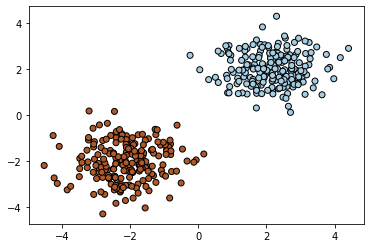

In [4]:
# Load linear dataset
X, y = make_blobs(n_samples=NB_SAMPLES, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### I.1 Maximum-A-Posteriori Estimate


In this "baseline", we reduce our posterior distribution $p(\pmb{w} | \mathcal{D})$ to a point estimate $\pmb{w}_{MAP}$. For a new sample $\pmb{x^*}$, the predictive distribution can then be approximated by
$$ p(\mathbf{y} = 1|\pmb{x^*},\mathcal{D}) = \int p(\mathbf{y} =1 |\pmb{x},\pmb{w})p(\pmb{w} | \mathcal{D})d\pmb{w} \approx p(y =1 |\pmb{x},\pmb{w}_{\textrm{MAP}}).$$
This approximation is called the **plug-in approximation**.

The point estimate corresponds to the Maximum-A-Posteriori minimum given by:
$$ \pmb{w}_{\textrm{MAP}} = arg \max_{\pmb{w}} p(\pmb{w} \vert \mathcal{D}) = arg \max_{\pmb{w}} p(\mathcal{D} \vert \pmb{w})p(\pmb{w}) = arg \max_{\pmb{w}} \prod_{n=1}^N p(y_n \vert \pmb{x}_n, \pmb{w})p(\pmb{w}) $$
Looking for the maximum solution of previous equation is equivalent to the minimum solution of $- \log p(\pmb{w} \vert \mathcal{D})$. In case of a Gaussian prior, it can further be derived as:
$$ \pmb{w}_{\textrm{MAP}} = arg \min_{\pmb{w}} \sum_{n=1}^N \big ( -y_n \log \sigma(\pmb{w}^T \pmb{x}_n + b) - (1-y_n) \log (1 - \sigma(\pmb{w}^T \pmb{x}_n + b)) + \frac{1}{2 \Sigma_0^2} \vert \vert \pmb{w} \vert \vert_2^2 \big ) $$

Note that:
- This actually correspond to the minimum given by the standard **cross-entropy** loss in classification with a weight decay regularization
- Unlike in linear regression, $\pmb{w}_{MAP}$ **cannot be computed analytically**
- But we can use optimization methods to compute it, e.g. **stochastic gradient descent**
- Nevertheless, we only obtain a **point-wise estimate**, and not a full distribution over parameters $\pmb{w}$


Consequently, **the objective is simply to implement and train a Logistic Regression model** with Pytorch and then compute $p(\mathbf{y} = 1|\pmb{x}^*,\mathcal{D})$ on a new sample $\pmb{x}^*$ as in a deterministic model.

In [6]:
class LogisticRegression(nn.Module):
    """ A Logistic Regression Model with sigmoid output in Pytorch"""
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.fc(x)
        return torch.sigmoid(out)

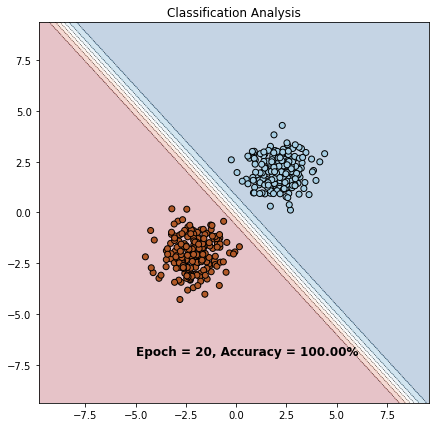

In [7]:
#@title **[CODING TASK]** Train a Logistic Regression model with stochastic gradient descent for 20 epochs.

net = LogisticRegression(input_size=X.shape[1])
net.train()
criterion = nn.BCELoss()

# L2 regularization is included in Pytorch's optimizer implementation
# as "weigth_decay" option
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=WEIGHT_DECAY)

fig, ax = plt.subplots(figsize=(7,7))

# ============ YOUR CODE HERE ============
# Train previously defined network for 20 epochs with SGD 
# and plot result for each epoch by uncommenting function below

for epoch in range(20):  # loop over the dataset multiple times
    # ============ YOUR CODE HERE ============
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    # For plotting and showing learning process at each epoch
    plot_decision_boundary(net, X, y, epoch, ((output>=0.5) == y).float().mean(), 
                          model_type='classic', tloc=TEXT_LOCATION)

**[Question 1.1]: Analyze the results provided by previous plot. Looking at $p(\mathbf{y}=1 | \pmb{x}, \pmb{w}_{\textrm{MAP}})$, what can you say about points far from train distribution?**

### I.2 Laplace Approximation


We will use Laplace approximation to estimate the intractable posterior $p(\pmb{w} | \mathcal{D})$.

Here, $p(\pmb{w} | \mathcal{D})$ is approximated with a normal distribution $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ where: 

- the mean of the normal distribution $\pmb{\mu}_{lap}$ corresponds to the mode of $p(\pmb{w} | \mathcal{D})$. In other words, it simply consists in taking the optimum weights of Maximum-A-Posteriori estimation : 
$$\pmb{\mu}_{lap} = \pmb{w}_{\textrm{MAP}} = \arg \min_{\pmb{w}} -\log p(\pmb{w} | \mathcal{D})$$. 
- the covariance matrix is obtained by computing the Hessian of the loss function $-\log p(\pmb{w} \vert \mathcal{D})$ at $\pmb{w}=\pmb{w}_{\textrm{MAP}}$: 
$$(\pmb{\Sigma}^2_{lap})^{-1} = \nabla\nabla_{\pmb{w}} [p(\pmb{w} \vert \mathcal{D}) ]_{\pmb{w}=\pmb{w}_{\textrm{MAP}}}$$

In [10]:
#@title **[CODING TASK]** Extract μ_lap from previously trained model. 
# NB: Select only weights parameters (without bias)

# ============ YOUR CODE HERE ============
w_map = net.fc.weight

To compute the Hessian, we first compute the gradient at $\pmb{w}_{\textrm{MAP}}$:

In [11]:
# Computing first derivative w.r.t to model's weights
optimizer.zero_grad()
output = net(X).squeeze()
loss = criterion(output, y) + net.fc.weight.norm()**2
gradf_weight = grad(loss, net.fc.weight, create_graph=True)[0]

In [13]:
#@title **[CODING TASK]** Compute the Hessian from the previous derivative
hess_weights = [
    (grad(gradf_weight[0][i], w_map, retain_graph=True)[0]).squeeze()
    for i in range(gradf_weight.shape[1])
]

# ============ YOUR CODE HERE ============
# Apply the same grad function on each scalar element of the gradient to get 
# each raw of the Hessian. Concatenate both and compute the covariance 
# by inverting the Hessian
# NB: to avoid accumulated gradient when debugging and running the cell 
# multiple times, you should convert your grad results to numpy straight away
hess_weights = torch.stack(hess_weights)
Sigma_laplace = torch.inverse(hess_weights)

We now compute the posterior approximate $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ with the parameters found. 

Given this distribution, we can compute the posterior thanks to Monte-Carlo sampling and plot results for the last epoch corresponding to $\pmb{w}_{\textrm{MAP}}$:

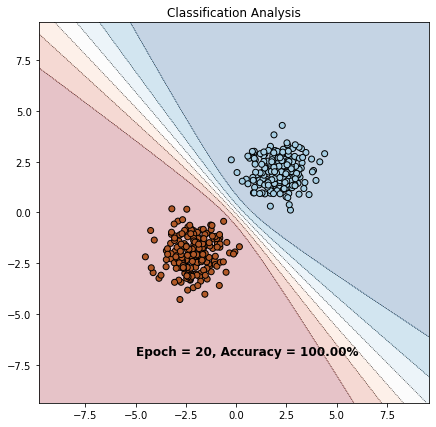

In [15]:
# Defining posterior distribution
laplace_posterior =  np.random.multivariate_normal(w_map.detach().numpy().reshape(2,), Sigma_laplace.detach().numpy(), NB_SAMPLES)

# Plotting results
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), model_type='laplace', 
                       tloc=TEXT_LOCATION, nsamples=NB_SAMPLES, posterior=laplace_posterior)

**[Question 1.2]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**

### I.3 Variational Inference

In this part, we will reimplement variational inference by hand with Pytorch tools. <br/><br/>

**Optimization problem**  
We define an approximating variational distribution $q_{\pmb{\theta}}(\pmb{w})$ parametrized by $\pmb{\theta}$ and minimize its Kullback-Leibler (KL) divergence with the unknown true posterior $p(\pmb{w} \vert \mathcal{D})$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_{\pmb{\theta}}(\pmb{w})$:

$$ arg \max_{\pmb{\theta}}~ \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \big [\underbrace{\log p(\mathcal{D} \vert \pmb{w})}_{likelihood} \big ] - \underbrace{\textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))}_{regularization} $$
where we have a likelihood term  and the KL divergence between the prior and the variational distribution.

Let’s first rewrite the KL-divergence term:
$$ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})) = \int q_{\pmb{\theta}} \log \frac{q_{\pmb{\theta}}(\pmb{w})}{p(\pmb{w})}d\pmb{w} = \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})}\big [\log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w})\big ] $$
As for the likelihood term, the KL-divergence can be written as an expectation over the approximate distribution $q_{\pmb{\theta}}(\pmb{w})$.

By assuming that samples are *i.i.d*, maximizing the ELBO is equivalent to minimizing the following loss:
$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \Big [ \log p(y_n \vert \pmb{x}_n, \pmb{w}) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w}) \big ) \Big ] $$
The KL-divergence is not dependent on $\mathcal{D}$, and can therefore be computed at the moment of sampling $\pmb{w}$. <br/><br/>

**Monte Carlo estimator**  
Deriving those expectations can be some tedious mathematics, or maybe not even possible. Luckily we can get estimates of the mean by taking samples from $q_{\pmb{\theta}}(\pmb{w})$ and average over those results.

Even more simple, we can show that using only one sample is stil an unbiased gradient estimator. Hence, loss function simply boils down to minimzing at each step:

$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \Big ( \log p(y_n \vert \pmb{x}_n, \pmb{w}_s) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}_s) - \log p(\pmb{w}_s) \big ) \Big )$$
where $\pmb{w}_s \sim q_{\pmb{\theta}}$ is a sample from the variational distribution. <br/><br/>

**Mean-field approximation**  
For simplicity, we assume a factorisation over the weights on each layer:
$$ q_{\pmb{\theta}}(\pmb{w}) = \prod_{l=1}^L q_{\pmb{\theta}}(\pmb{W}_l) = \prod_{l=1}^L \mathcal{N}(\pmb{W}_l; \pmb{\mu}_l, \pmb{\Sigma}^2_l) $$
As we chose a Gaussian prior $p(\pmb{W}_l)$, we also defined here $q_{\pmb{\theta}}(\pmb{W}_l)$ as a Gaussian distribution for its conjugate properties.For modelisation purposes, we take $q_{\pmb{\theta}}(\pmb{W}_l)$ to be isotropic, i.e. $\pmb{\Sigma}_l$ is diagonal.
<br/><br/>

**Reparametrization trick**  
If we start taking samples from $q_{\pmb{\theta}}$, we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples $\pmb{w}_{l,s} \sim \mathcal{N}(\pmb{\mu}_{l}, \pmb{\Sigma}_{l}^2)$ from the distribution.

Instead of sampling directly from the variational distribution, we sample from a centered isotropic multivariate Gaussian and recreate samples from the variational distribution. Now the stochasticity of $\pmb{\varepsilon}$ is external and will not prevent the flow of gradients.
$$ \pmb{w}_{l,s} = \pmb{\mu}_{l}+ \pmb{\Sigma}_{l}\odot\pmb{\varepsilon}_s$$
where $\pmb{\varepsilon}_s \sim \mathcal{N}(0,\pmb{I}_l)$, with $\pmb{I}_l \in \mathbb{R}^l$ the identity vector of size $l$.
<br/><br/>  

**Predictive distribution**  
For a new sample $\pmb{x^*}$, the predictive distribution can be approximated using **Monte Carlo sampling**:
\begin{equation}
p(\mathbf{y} =1|\pmb{x}^*,\mathcal{D}) \approx \int p(\mathbf{y} = 1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(\mathbf{y}=1|\pmb{x}^*,\pmb{w}_s)
\end{equation}
where $\pmb{w}_s \sim q^*_{\pmb{\theta}}$ are samples from the optimum variational distribution.

#### Step 1: Implement a variational layer

Let's first implement variational inference for a single layer. Remind that we defined our Logistic regression model as $f(x) = \sigma(w^T x + b)$ where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function. As such, we need to place Gaussian distributions on parameters $w$ and $b$.  

**Implementation constraint** Variance can not be negative. To avoid numerical issues, we will use $\pmb{\rho}$. Std can be retrieve with the following formula:
$$ \pmb{\Sigma} = \log(1 + e^{\pmb{\rho}}) $$ 

In [16]:
#@title **[CODING TASK]** Implement a variational layer from scratch

class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, accumulated_kl_div):
        super().__init__()
        self.accumulated_kl_div = accumulated_kl_div
      
        # ============ YOUR CODE HERE ============
        # Initialize the variational parameters for weight and bias
        # with nn.Parameter.
        # Mean should be initialised to zeros and rho to ones
        self.w_mu = nn.Parameter(torch.zeros(input_size, output_size))
        self.w_rho = nn.Parameter(torch.ones(input_size, output_size))
        self.b_mu = nn.Parameter(torch.zeros(output_size))
        self.b_rho = nn.Parameter(torch.ones(output_size))
        
    def sampling(self, mu, rho):
        "Sample weights using the reparametrization trick"
        # ============ YOUR CODE HERE ============
        # Given parameter mu and rho, return sampling using 
        # the reparametrization trick.
        # NB: you may look for torch.randn_like...
        return mu + (1 + rho.exp()).log() * torch.randn_like(mu)
    
    def kl_divergence(self, z, mu_theta, rho_theta, prior_sd=1):
        "Computing the KL-divergence term for these weight's parameters"
        log_prior = dist.Normal(0, prior_sd).log_prob(z)
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(rho_theta))).log_prob(z)
        return (log_p_q - log_prior).sum() / X.shape[0]

    def forward(self, x):
        "Usual forward function for pytorch layer"
        # ============ YOUR CODE HERE ============
        # Sample parameters w and b using self.sampling
        # Then, perform a forward pass using those sampled parameters
        w = self.sampling(self.w_mu, self.w_rho)
        b = self.sampling(self.b_mu, self.b_rho)
        out = torch.mm(x, w) + b
      
        # Compute KL-div loss for training
        self.accumulated_kl_div[0] += self.kl_divergence(w, self.w_mu, self.w_rho)
        self.accumulated_kl_div[0] += self.kl_divergence(b, self.b_mu, self.b_rho)
        
        return out

#### Step 2: Variational Logistic Regression

Now, let's use this `LinearVariational` layer in a Logistic regression model.

In [17]:
class VariationalLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)
        self.fc_var =  LinearVariational(input_size, 1,self.accumulated_kl_div)
    
    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0
            
    def forward(self, x):
        out = self.fc_var(x)
        return torch.sigmoid(out)


def elbo(input, target, model):
    negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
    return negative_log_likelihood + model.accumulated_kl_div[0] / input.shape[0]

We can now train our variational model as any other network in Pytorch

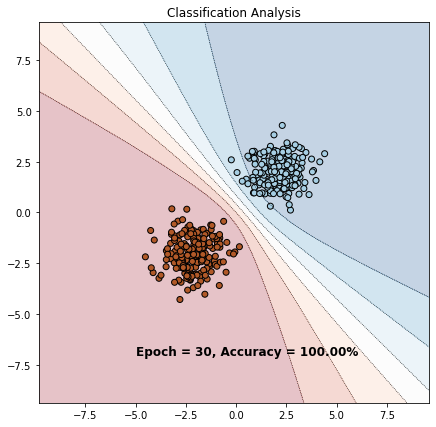

In [18]:
var_net = VariationalLogisticRegression(input_size=X.shape[1])
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1,  weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(30):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # Computing prediction for visualization purpose
    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()

    # For plotting and showing learning process at each epoch
    plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

**[Question 1.3]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**

## Part II: Bayesian Neural Networks


Moving on to a non-linear dataset, we will leverage our variational implementation to a Multi-Layer Perceptron (MLP). Finally, we will also review one last approximate inference method which has the particularity to be very easy to implement: Monte-Carlo Dropout

### II.0 Dataset

In [19]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

NOISE_MOON = 0.05 #@param
WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 100 #@param
TEXT_LOCATION = (-1.5, -1.5)

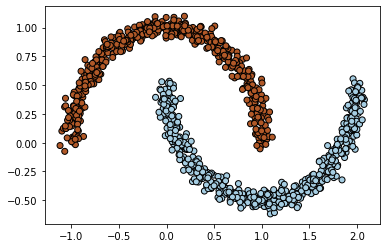

In [20]:
# Load two moons dataset
X, y = make_moons (n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### II.1 Variational Inference with Bayesian Neural Networks

Such as for Logistic Regression, we will use `LinearVariational` layer to define a MLP with 1 hidden layer.





In [21]:
#@title **[CODING TASK]** Implement a Variational MLP

class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)

        # ============ YOUR CODE HERE ============
        # Define a variational MLP with 1 hidden layer and ReLU activation
        self.hidden_layer = LinearVariational(input_size, hidden_size, self.accumulated_kl_div)
        self.fc = LinearVariational(hidden_size, 1, self.accumulated_kl_div)
        self.act = nn.ReLU()
    
    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0
            
    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        output = self.hidden_layer(x)
        output = self.act(output)
        output = self.fc(output)
        return torch.sigmoid(output)

We can now train our variational model as any other network in Pytorch

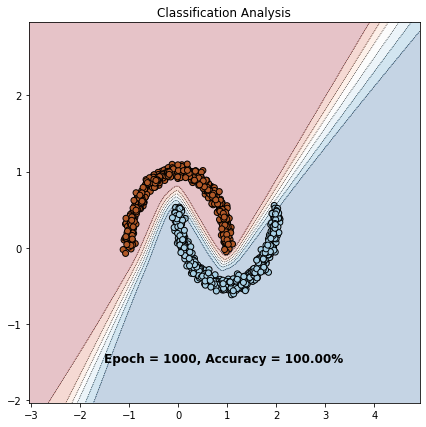

In [22]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=50)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(1000):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%50==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

### II.2 Monte Carlo Dropout

Training a neural network with randomly dropping some activations, such as with dropout layers, can actually be seen as an **approximate variational inference method**!

[Gal and Ghahramani, 2016] showed this can be fullfilled for:
- $p(\pmb{w}) = \prod_l p(\pmb{W}_l) = \prod_l \mathcal{MN}(\pmb{W}_l; 0, I/ l_i^2, I)$ $\Rightarrow$ Multivariate Gaussian distribution factorized over layers
- $q(\pmb{w}) = \prod_l q(\pmb{W}_l) = \prod_l \textrm{diag}(\varepsilon_l)\odot\pmb{M}_l $ with $\varepsilon_l \sim \textrm{Ber}(1-p_l)$.

We will now implement a MLP with dropout layers and perform Monte-Carlo sampling to obtain the predictive distribution $p(\mathbf{y} \vert \pmb{x}^*, \pmb{w})$ for a new sample $\pmb{x}^*$.

In [23]:
#@title **[CODING TASK]** Implement a MLP with dropout (p=0.2)
# Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout 
# layer should be also activated during test time.
# (Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # ============ YOUR CODE HERE ============
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        output = self.hidden_layer(x)
        output = self.act(output)
        output = F.dropout(output, p=0.2, training=self.training)
        output = self.fc(output)
        return torch.sigmoid(output)

We train our model as usual:

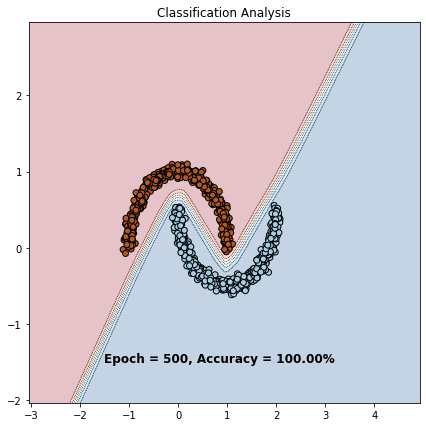

In [24]:
net = MLP(input_size=X.shape[1], hidden_size=50)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch, uncomment and indent line below
    if (epoch+1)%50==0:
        plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='classic')
        

Now let's look at the results given by MC Dropout:

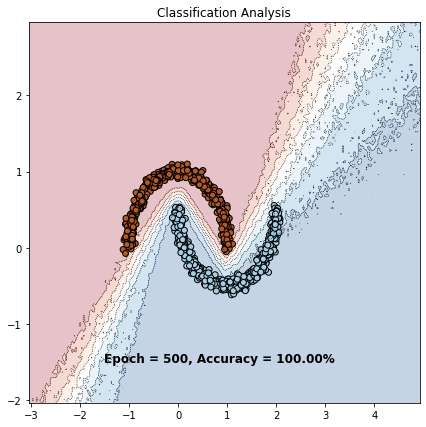

In [25]:
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='mcdropout')

**[Question 2.1]: Again, analyze the results showed on plot. What is the benefit of MC Dropout variational inference over Bayesian Logistic Regression with variational inference?**